# Base Fee Manipulation In Ethereum's EIP-1559 Transaction Fee Mechanism

This file provides the code to reproduce the simulation's for the paper Base Fee Manipulation In Ethereum's EIP-15591 Transaction Fee Mechanism.

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from  enum import Enum
import random
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import pickle
import math

In [2]:
#colors
class Color(Enum):
    LIGHTGREEN = "#96E6B3" 
    RED = "#DA3E52" 
    YELLOW = "#FFE66D"
    VIOLET = "#7E6B8F"
    LIGHTBLUE = "#A3D9FF"
    DARKBLUE = "#06AED5"
    GRAY = "#A9A9A9"
    PINK = "#FF6B6B"
    TURQUOISE = "#4ECDC4"
    GREEN = "#7FD1B9"

In [3]:
#parameters
starget = 1
close = 0.99
runs = 10000

In [4]:
#function to calculate savg
def savg(prevsavg,s,q): 
    return (1-q)*s +q*prevsavg

#function to calculate the basefee under the mitigation
def basefee(prevbasefee,savg,f): 
    return prevbasefee*(1+f*(savg-starget)/starget)

#function to calculate the basefee under EIP-1559
def basefeeEIP(prevbasefee,s,f): 
    return prevbasefee*(1+f*(s-starget)/starget)

In [5]:
#simulation of basefee under the mitigation
def mitigation(px,f,btarget,eps,a,q):
    payoutattackTotal = []
    payouthonestTotal = []
    counterTotal = []

    for i in range(runs):
        ATTACK = True
        payoutattack = 0
        payouthonest= eps*starget
        counter = 0
        svagvalue = savg(starget,0,q)
        basefeevalue = basefee(btarget,svagvalue,f)

        while ATTACK:
            counter += 1
            miner = random.choices(population=['x','y'],weights=[px,1-px])[0]
            if miner == "x": 
                payoutattack+= ((1-a)*eps + (btarget-basefeevalue))*starget
                payouthonest+= eps*starget
                svagvalue = savg(svagvalue,starget,q)
                basefeevalue = basefee(basefeevalue,svagvalue,f)
            else: 
                svagvalue = savg(svagvalue,2*starget,q)
                basefeevalue = basefee(basefeevalue,svagvalue,f)
            if basefeevalue >=close*btarget: 
                ATTACK =False

        payoutattackTotal.append(payoutattack)
        payouthonestTotal.append(payouthonest)
        counterTotal.append(counter)
       
    relativeDiff= [(i-j) for i, j in zip(payoutattackTotal, payouthonestTotal)]
    return relativeDiff, counterTotal




In [6]:
#simulation of basefee under EIP-1559
def EIP(px,f,btarget,eps,a):

    payoutattackTotalEIP = []
    payouthonestTotalEIP = []
    counterTotalEIP = []

    for i in range(runs):
        ATTACK = True
        payoutattackEIP = 0
        payouthonestEIP= eps*starget
        counter = 0
        basefeevalue = basefeeEIP(btarget,0,f)

        while ATTACK:
            counter +=1 
            miner = random.choices(population=['x','y'],weights=[px,1-px])[0]
            if miner == "x": 
                payoutattackEIP+= ((1-a)*eps + (btarget-basefeevalue))*starget
                payouthonestEIP+= eps*starget
                basefeevalue = basefeeEIP(basefeevalue,starget,f)
            else: 
                basefeevalue = basefeeEIP(basefeevalue,2*starget,f)
            if basefeevalue >=close*btarget: 
                ATTACK =False     

        payoutattackTotalEIP.append(payoutattackEIP)
        payouthonestTotalEIP.append(payouthonestEIP)
        counterTotalEIP.append(counter)

    relativeDiff= [(i-j) for i, j in zip(payoutattackTotalEIP, payouthonestTotalEIP)]    
    return relativeDiff, counterTotalEIP

## Profitability of attack under EIP-1559 and the proposed mitigation

The produced plots corresponds to the plots in Figure 5.

In [7]:
#plot parameters
plt.rcParams["figure.figsize"] = (2.6,1.4) 
font = {'family' : 'sans-serif', 'size'   : 6.3}
matplotlib.rc('font', **font)   

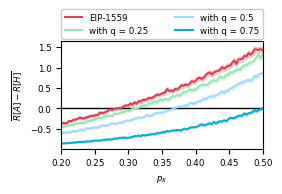

In [8]:
#set parameters
px = 0.4
q = [0.25,0.5,0.75]
f = 1/8
btarget = 25
a =0.5
eps  = 1
pxs = np.linspace(0.2, 0.5, num=100)

#initialize lists
xs =[]
ys =[]
zs = []
y1s=[]
z1s =[]
y2s=[]
z2s =[]
y3s=[]
z3s =[]

#run simulations
for px in pxs:
    xs += [px]*runs
    y, z = EIP(px,f,btarget,eps,a)
    zs += z 
    ys += y
    y1, z1 = mitigation(px,f,btarget,eps,a,q[0])
    y1s +=y1
    z1s +=z1
    y2, z2 = mitigation(px,f,btarget,eps,a,q[1])
    y2s +=y2
    z2s +=z2
    y3, z3 = mitigation(px,f,btarget,eps,a,q[2])
    y3s +=y3
    z3s +=z3

#plot
plt.axhline(0,color ="black",linewidth = 1)
ax = sns.lineplot(x = xs, y = ys,label = "EIP-1559", color = Color.RED.value)
ax = sns.lineplot(x = xs, y = y1s,label = "with q = 0.25",color = Color.LIGHTGREEN.value)
ax = sns.lineplot(x = xs, y = y2s,label = "with q = 0.5",color = Color.LIGHTBLUE.value)
ax = sns.lineplot(x = xs, y = y3s,label = "with q = 0.75",color = Color.DARKBLUE.value)
plt.xlim(pxs[0],pxs[-1])
plt.ylabel(r"$\overline{R[A]-R[H]}$")
plt.xlabel(r"$p_x$")
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()

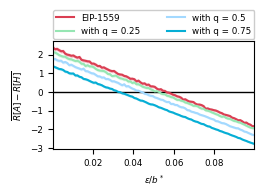

In [9]:
#set parameters
px = 0.4
q = [0.25,0.5,0.7]
f = 1/8
btarget = 25
a =0.5
epss = np.linspace(0.0001, 0.09999, num=100)

#initialize lists
xs =[]
ys =[]
y1s=[]
y2s = []
y3s = []
zs = []
z1s =[]
z2s = []
z3s = []

#run simulations
for eps in epss:
    xs += [eps]*runs
    y, z = EIP(px,f,btarget,btarget*eps,a)
    zs += z 
    ys += y
    y1, z1 = mitigation(px,f,btarget,btarget*eps,a,q[0])
    y1s +=y1
    z1s +=z1
    y2, z2 = mitigation(px,f,btarget,btarget*eps,a,q[1])
    y2s +=y2
    z2s +=z2
    y3, z3 = mitigation(px,f,btarget,btarget*eps,a,q[2])
    y3s +=y3
    z3s +=z3

#plot
plt.axhline(0,color ="black",linewidth = 1)
ax = sns.lineplot(x = xs, y = ys,label = "EIP-1559", color = Color.RED.value)
ax = sns.lineplot(x = xs, y = y1s,label = "with q = 0.25",color = Color.LIGHTGREEN.value)
ax = sns.lineplot(x = xs, y = y2s,label = "with q = 0.5",color = Color.LIGHTBLUE.value)
ax = sns.lineplot(x = xs, y = y3s,label = "with q = 0.75",color = Color.DARKBLUE.value)
plt.xlim(epss[0],epss[-1])
plt.ylabel(r"$\overline{R[A]-R[H]}$")
plt.xlabel(r"$\varepsilon/b^*$")
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()

## Comparison of attack profitability
The produced plots corresponds to the plots in Figure 6. 

In [10]:
#plot parameters
plt.rcParams["figure.figsize"] = (1.5,1.4) 
font = {'family' : 'sans-serif', 'size'   : 6.3}
matplotlib.rc('font', **font)   

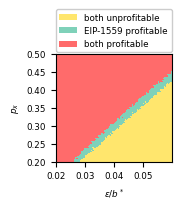

In [11]:
#run simulation for q = 0.25
pxs = np.linspace(0.2, 0.5, num=100)
epss = np.linspace(0.02, 0.06, num=100)
px = 0.4
q = 0.25
f = 1/8
btarget = 25
a =0.5
eps  = 1
pxs1, epss1 = np.meshgrid(pxs, epss)
Z = np.empty(shape=(len(epss),len(pxs)))
for i in range(len(pxs)): 
      px = pxs[i]
      for j in range(len(epss)):
            eps =epss[j]
            y1, z1 = mitigation(px,f,btarget,btarget*eps,a,q)
            y1avg  = sum(y1) / len(y1)
            y2, z2 = EIP(px,f,btarget,btarget*eps,a)
            y2avg  = sum(y2) / len(y2)
            if y1avg >0 and y2avg>0: 
                  Z[i, j] =1
            elif y2avg>0: 
                  Z[i, j] =0
            else: 
                  Z[i, j] =-1

#plot
cmap = ListedColormap([Color.YELLOW.value, Color.GREEN.value, Color.PINK.value])# 11 discrete colors
plt.xlabel(r"$\varepsilon/b^*$")
plt.ylabel(r"$p_x$")
legend_elements = [Patch(facecolor=Color.YELLOW.value, label=r"both unprofitable"),
                  Patch(facecolor=Color.GREEN.value, label=r"EIP-1559 profitable"),
                  Patch(facecolor=Color.PINK.value, label=r"both profitable")]
ax = plt.gca()
plt.imshow(Z, cmap=cmap, interpolation='gaussian', vmin = -1,vmax =1,extent=[0.02, 0.059999999,0.2,0.5],origin='lower', aspect="auto")#
lgd = ax.legend(handles=legend_elements,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=1, mode="expand", borderaxespad=0.)
plt.show()

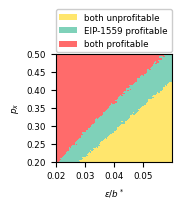

In [12]:
#run simulation for q = 0.5
pxs = np.linspace(0.2, 0.5, num=100)
epss = np.linspace(0.02, 0.06, num=100)
px = 0.4
q = 0.5
f = 1/8
btarget = 25
a =0.5
eps  = 1
pxs1, epss1 = np.meshgrid(pxs, epss)
Z = np.empty(shape=(len(epss),len(pxs)))
for i in range(len(pxs)): 
      px = pxs[i]
      for j in range(len(epss)):
            eps =epss[j]
            y1, z1 = mitigation(px,f,btarget,btarget*eps,a,q)
            y1avg  = sum(y1) / len(y1)
            y2, z2 = EIP(px,f,btarget,btarget*eps,a)
            y2avg  = sum(y2) / len(y2)
            if y1avg >0 and y2avg>0: 
                  Z[i, j] =1
            elif y2avg>0: 
                  Z[i, j] =0
            else: 
                  Z[i, j] =-1

#plot
cmap = ListedColormap([Color.YELLOW.value, Color.GREEN.value, Color.PINK.value])# 11 discrete colors
plt.xlabel(r"$\varepsilon/b^*$")
plt.ylabel(r"$p_x$")
legend_elements = [Patch(facecolor=Color.YELLOW.value, label=r"both unprofitable"),
                  Patch(facecolor=Color.GREEN.value, label=r"EIP-1559 profitable"),
                  Patch(facecolor=Color.PINK.value, label=r"both profitable")]
ax = plt.gca()
plt.imshow(Z, cmap=cmap, interpolation='gaussian', vmin = -1,vmax =1,extent=[0.02, 0.059999999,0.2,0.5],origin='lower', aspect="auto")#
lgd = ax.legend(handles=legend_elements,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=1, mode="expand", borderaxespad=0.)
plt.show()

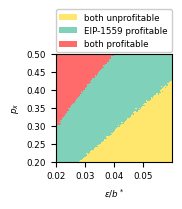

In [13]:
#run simulation for q = 0.75
pxs = np.linspace(0.2, 0.5, num=100)
epss = np.linspace(0.02, 0.06, num=100)
px = 0.4
q = 0.75
f = 1/8
btarget = 25
a =0.5
eps  = 1
pxs1, epss1 = np.meshgrid(pxs, epss)
Z = np.empty(shape=(len(epss),len(pxs)))
for i in range(len(pxs)): 
      px = pxs[i]
      for j in range(len(epss)):
            eps =epss[j]
            y1, z1 = mitigation(px,f,btarget,btarget*eps,a,q)
            y1avg  = sum(y1) / len(y1)
            y2, z2 = EIP(px,f,btarget,btarget*eps,a)
            y2avg  = sum(y2) / len(y2)
            if y1avg >0 and y2avg>0: 
                  Z[i, j] =1
            elif y2avg>0: 
                  Z[i, j] =0
            else: 
                  Z[i, j] =-1

#plot
cmap = ListedColormap([Color.YELLOW.value, Color.GREEN.value, Color.PINK.value])# 11 discrete colors
plt.xlabel(r"$\varepsilon/b^*$")
plt.ylabel(r"$p_x$")
legend_elements = [Patch(facecolor=Color.YELLOW.value, label=r"both unprofitable"),
                  Patch(facecolor=Color.GREEN.value, label=r"EIP-1559 profitable"),
                  Patch(facecolor=Color.PINK.value, label=r"both profitable")]
ax = plt.gca()
plt.imshow(Z, cmap=cmap, interpolation='gaussian', vmin = -1,vmax =1,extent=[0.02, 0.059999999,0.2,0.5],origin='lower', aspect="auto")#
lgd = ax.legend(handles=legend_elements,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=1, mode="expand", borderaxespad=0.)
plt.show()

## Number of consecutive full blocks (T) required to increase the base fee
The produced plots corresponds to the plots in Figure 7.  

In [14]:
#plot parameters
plt.rcParams["figure.figsize"] = (3,1.4) 
font = {'family' : 'sans-serif', 'size'   : 6.3}
matplotlib.rc('font', **font)   

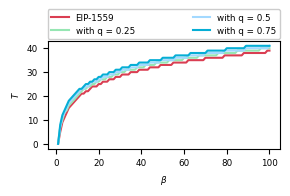

In [15]:
#set parameters
f = 1/8
qs =[0.25,0.5,0.75]
betas = np.linspace(1,100,num = 100)

#initialize lists
T = []
T1 = []
T2 = []
T3 = []

#run simulations
for beta in betas: 
    T.append(math.floor(np.log(beta)/np.log(1+f)))
    prod = 1
    k = 0
    while prod < beta:         
        prod *= (1+f*(1-qs[0]**k))
        k += 1
    T1.append(max(0,k-1))
    k = 0
    prod = 1
    while prod < beta: 
        
        prod *= (1+f*(1-qs[1]**k))
        k += 1
    T2.append(max(0,k-1))    
    k = 0
    prod = 1
    while prod < beta: 
        k += 1
        prod *= (1+f*(1-qs[2]**k))        
    T3.append(max(0,k-1))

#plot
ax = plt.gca()
plt.plot(betas,T,label = "EIP-1559", color = Color.RED.value)
plt.plot(betas,T1,label = "with q = 0.25",color = Color.LIGHTGREEN.value)
plt.plot(betas,T2,label = "with q = 0.5",color = Color.LIGHTBLUE.value)
plt.plot(betas,T3,label = "with q = 0.75",color = Color.DARKBLUE.value)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$T$")
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,facecolor ="white", framealpha=1, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,  ncol=2, mode="expand", borderaxespad=0.)
plt.show()
